# doublet cleaning

In [1]:
library(Seurat)
library(dplyr)
library(magrittr)
IRdisplay::display_html("<style> .container { width:95% !important; } </style>")
library("xlsx")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
cntl.data <-Read10X(data.dir = "/media/garret/New Volume/scRNAseq_data/Yoshiko/180725LHb/raw_gene_bc_matrices/mm10")
colnames(cntl.data) = paste0(colnames(cntl.data),"cntl")
cntl<- CreateSeuratObject(counts = cntl.data, min.cells = 3, min.features = 200, project = "10X_LHb")
cntl@meta.data$stim <- "cntl"
stim.data <-Read10X(data.dir = "/media/garret/New Volume/scRNAseq_data/Yoshiko/180905LHb/raw_gene_bc_matrices/mm10")
colnames(stim.data) = paste0(colnames(stim.data),"stim")
stim<- CreateSeuratObject(counts = stim.data, min.cells = 3, min.features = 200, project = "10X_LHb")
stim@meta.data$stim <- "stim"


mito.features <- grep(pattern = "^mt-", x = rownames(x = cntl), value = TRUE)
percent.mito <- Matrix::colSums(x = GetAssayData(object = cntl, slot = 'counts')[mito.features, ]) / Matrix::colSums(x = GetAssayData(object = cntl, slot = 'counts'))
cntl[['percent.mito']] <- percent.mito
mito.features <- grep(pattern = "^mt-", x = rownames(x = stim), value = TRUE)
percent.mito <- Matrix::colSums(x = GetAssayData(object = stim, slot = 'counts')[mito.features, ]) / Matrix::colSums(x = GetAssayData(object = stim, slot = 'counts'))
stim[['percent.mito']] <- percent.mito

cntl <- subset(x = cntl, subset = nCount_RNA > 700 & nCount_RNA < 15000 & percent.mito < 0.20)
stim <- subset(x = stim, subset = nCount_RNA > 700 & nCount_RNA < 15000 & percent.mito < 0.20)

cntl<- NormalizeData(object = cntl,verbose = FALSE) 
stim<- NormalizeData(object = stim,verbose = FALSE) 

cntl<- FindVariableFeatures(object =cntl,selection.method = "vst", nfeatures = 2000, verbose = FALSE)
stim<- FindVariableFeatures(object =stim,selection.method = "vst", nfeatures = 2000, verbose = FALSE)

cntl<- ScaleData(object = cntl, features = rownames(x =cntl), vars.to.regress = c("nCount_RNA", "percent.mito"))
stim<- ScaleData(object = stim, features = rownames(x =stim), vars.to.regress = c("nCount_RNA", "percent.mito"))

cntl<- RunPCA(object = cntl, features = VariableFeatures(object =cntl), verbose = FALSE)
stim<- RunPCA(object = stim, features = VariableFeatures(object =stim), verbose = FALSE)

cntl <- JackStraw(object =cntl, num.replicate = 100)
stim<- JackStraw(object =stim, num.replicate = 100)

cntl<- ScoreJackStraw(object = cntl, dims = 1:20)
stim<- ScoreJackStraw(object = stim, dims = 1:20)


cntl<- FindNeighbors(object =cntl, dims = 1:30)
cntl<- FindClusters(object = cntl, resolution = 0.8)
stim<- FindNeighbors(object =stim, dims = 1:30)
stim <- FindClusters(object = stim, resolution = 0.8)



Regressing out nCount_RNA, percent.mito
Centering and scaling data matrix
Regressing out nCount_RNA, percent.mito
Centering and scaling data matrix
Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6200
Number of edges: 240314

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9070
Number of communities: 24
Elapsed time: 0 seconds


Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6168
Number of edges: 227894

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9166
Number of communities: 27
Elapsed time: 0 seconds


In [4]:
saveRDS(cntl,file = "/media/garret/New Volume/scRNAseq_data/Yoshiko/180725LHb/all_cells/gene2000_30/cntl.rds")
saveRDS(stim,file = "/media/garret/New Volume/scRNAseq_data/Yoshiko/180725LHb/all_cells/gene2000_30/stim.rds")

In [2]:
cntl<-readRDS(file = "/media/garret/New Volume/scRNAseq_data/Yoshiko/180725LHb/all_cells/gene2000_30/cntl.rds")
stim<-readRDS(file = "/media/garret/New Volume/scRNAseq_data/Yoshiko/180725LHb/all_cells/gene2000_30/stim.rds")


In [5]:
counts<-as.matrix(cntl@assays$RNA@data)
write.table(data.frame("GENE"=rownames(counts),counts),file="/media/garret/New Volume/scRNAseq_data/Yoshiko/180725LHb/all_cells/gene2000_30/doublet/counts.txt",row.names=FALSE,sep="\t")

counts<-as.matrix(stim@assays$RNA@data)
write.table(data.frame("GENE"=rownames(counts),counts),file="/media/garret/New Volume/scRNAseq_data/Yoshiko/180905LHb/all_cells/gene2000_30/doublet/counts.txt",row.names=FALSE,sep="\t")


In [6]:
markers <- FindAllMarkers(object = cntl, only.pos = TRUE, min.pct = 0.25)
top_50<-markers %>% group_by(cluster) %>% top_n(50)
write.table(data.frame("test"=as.character(rownames(top_50)),top_50),file="/media/garret/New Volume/scRNAseq_data/Yoshiko/180725LHb/all_cells/gene2000_30/doublet/Top50Genes.txt",row.names=FALSE,col.names=c("",colnames(top_50)),sep="\t",eol="\n")

markers <- FindAllMarkers(object = stim, only.pos = TRUE, min.pct = 0.25)
top_50<-markers %>% group_by(cluster) %>% top_n(50)
write.table(data.frame("test"=as.character(rownames(top_50)),top_50),file="/media/garret/New Volume/scRNAseq_data/Yoshiko/180905LHb/all_cells/gene2000_30/doublet/Top50Genes.txt",row.names=FALSE,col.names=c("",colnames(top_50)),sep="\t",eol="\n")


Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5
Calculating cluster 6
Calculating cluster 7
Calculating cluster 8
Calculating cluster 9
Calculating cluster 10
Calculating cluster 11
Calculating cluster 12
Calculating cluster 13
Calculating cluster 14
Calculating cluster 15
Calculating cluster 16
Calculating cluster 17
Calculating cluster 18
Calculating cluster 19
Calculating cluster 20
Calculating cluster 21
Calculating cluster 22
Calculating cluster 23
Selecting by gene
Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5
Calculating cluster 6
Calculating cluster 7
Calculating cluster 8
Calculating cluster 9
Calculating cluster 10
Calculating cluster 11
Calculating cluster 12
Calculating cluster 13
Calculating cluster 14
Calculating cluster 15
Calculating cluster 16
Calculating cluster 17
Calculating cluster 18
Calculating c

In [7]:
cluster<-Idents(object=cntl)
cluster<-as.matrix(cluster)
cluster[,1]<-as.character(cluster[,1])
cluster[,0]<-as.character(cluster[,0])
cluster<-data.frame("x"=rownames(cluster),cluster)
write.table(cluster,file="/media/garret/New Volume/scRNAseq_data/Yoshiko/180725LHb/all_cells/gene2000_30/doublet/Cluster.txt",row.names=FALSE,col.names=c("","x"),sep="\t",eol="\n")

cluster<-Idents(object=stim)
cluster<-as.matrix(cluster)
cluster[,1]<-as.character(cluster[,1])
cluster[,0]<-as.character(cluster[,0])
cluster<-data.frame("x"=rownames(cluster),cluster)
write.table(cluster,file="/media/garret/New Volume/scRNAseq_data/Yoshiko/180905LHb/all_cells/gene2000_30/doublet/Cluster.txt",row.names=FALSE,col.names=c("","x"),sep="\t",eol="\n")


Loading packages...
Reading data...
Processing raw data...
Combining similar clusters...
Creating synthetic doublet profiles...
Step 1: Removing possible doublets...
Step 2: Re-clustering possible doublets...
Step 3: Rescuing cells with unique gene expression...
Finished!


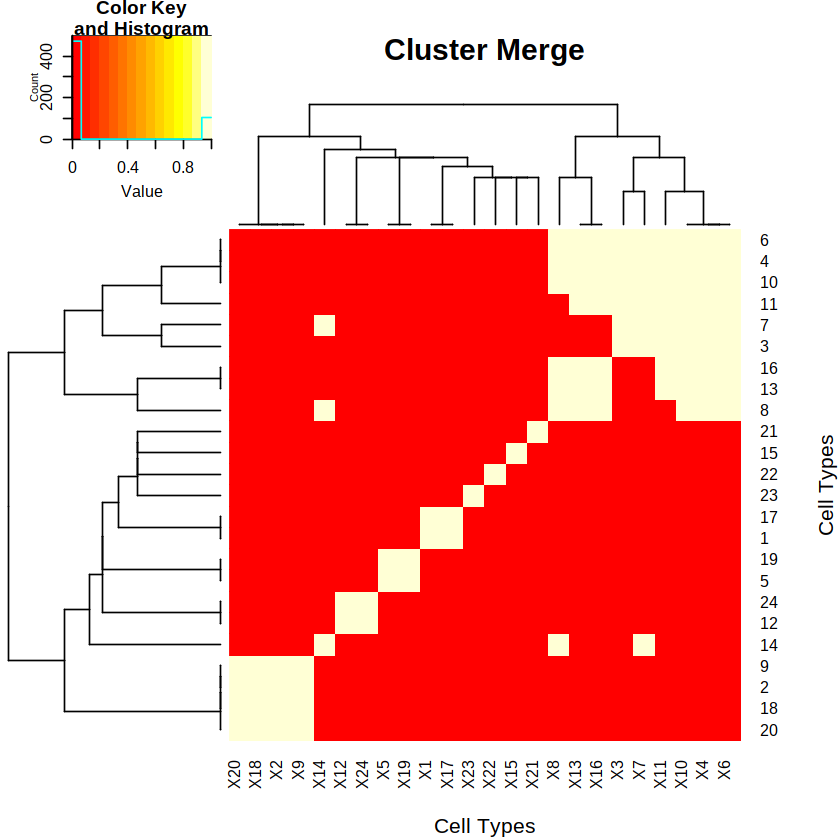

In [9]:
library("DoubletDecon")
location="/media/garret/New Volume/scRNAseq_data/Yoshiko/180725LHb/all_cells/gene2000_30/doublet/" #Update as needed 
expressionFile=paste0(location, "counts.txt")
genesFile=paste0(location, "Top50Genes.txt")
clustersFile=paste0(location, "Cluster.txt")

newFiles=Seurat_Pre_Process(expressionFile, genesFile, clustersFile)

results=Main_Doublet_Decon(rawDataFile=newFiles$newExpressionFile, 
                           groupsFile=newFiles$newGroupsFile, 
                           filename="cntl", 
                           location=location,
                           fullDataFile=NULL, 
                           removeCC=FALSE, 
                           species="mmu", 
                           rhop=1.1, 
                           write=TRUE, 
                           PMF=TRUE, 
                           useFull=FALSE, 
                           heatmap=FALSE,
                           centroids=TRUE,
                           num_doubs=100, 
                           only50=TRUE,
                           min_uniq=4)

Loading packages...
Reading data...
Processing raw data...
Combining similar clusters...
Creating synthetic doublet profiles...
Step 1: Removing possible doublets...
Step 2: Re-clustering possible doublets...
Step 3: Rescuing cells with unique gene expression...
Finished!


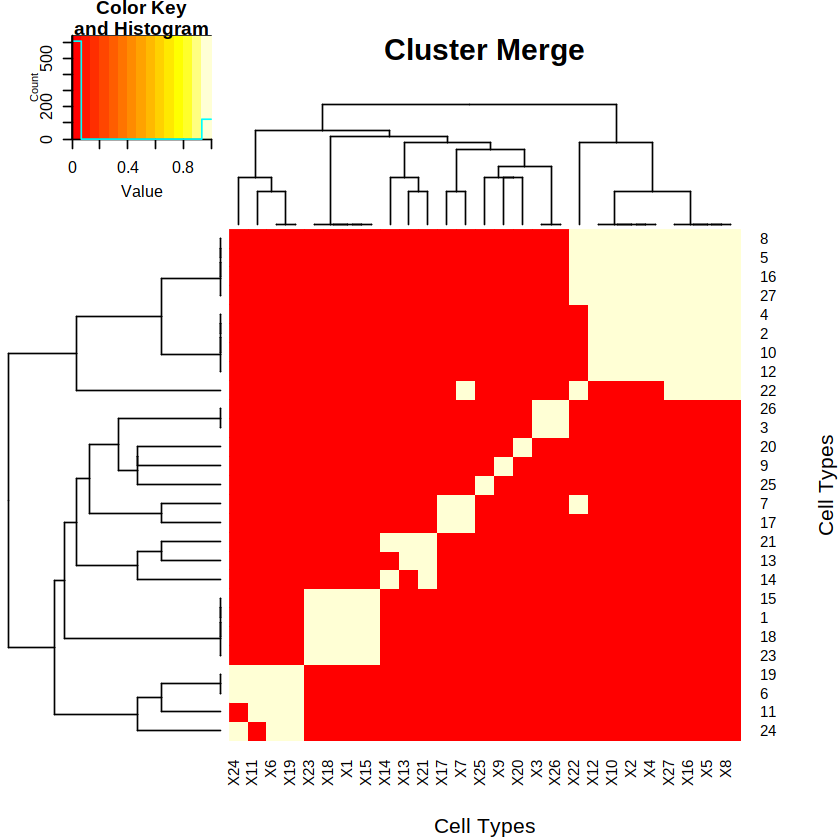

In [10]:
library("DoubletDecon")
location="/media/garret/New Volume/scRNAseq_data/Yoshiko/180905LHb/all_cells/gene2000_30/doublet/" #Update as needed 
expressionFile=paste0(location, "counts.txt")
genesFile=paste0(location, "Top50Genes.txt")
clustersFile=paste0(location, "Cluster.txt")

newFiles=Seurat_Pre_Process(expressionFile, genesFile, clustersFile)

results=Main_Doublet_Decon(rawDataFile=newFiles$newExpressionFile, 
                           groupsFile=newFiles$newGroupsFile, 
                           filename="cntl", 
                           location=location,
                           fullDataFile=NULL, 
                           removeCC=FALSE, 
                           species="mmu", 
                           rhop=1.1, 
                           write=TRUE, 
                           PMF=TRUE, 
                           useFull=FALSE, 
                           heatmap=FALSE,
                           centroids=TRUE,
                           num_doubs=100, 
                           only50=TRUE,
                           min_uniq=4)